# Tutorial for using *ewstools*

By the end of this tutorial you should know how to:
- Put your data into an *ewstools* TimeSeries object
- Detrend your data using a specific filter and bandwidth
- Compute CSD-based early warning signals and Kendall tau values
- Get predictions from the DL classifiers trained in the article by [Bury et al. (2021)](https://www.pnas.org/doi/10.1073/pnas.2106140118)
- Obtain and visualise the output from *ewstools*

Total run time : 2 min 18 s on Macbook Air (M1, 2020)


## Import libraries
The following libraries are necessary installations for this script

In [1]:
# Start timer to record execution time of notebook
import time
start_time = time.time()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ewstools

In [3]:
# Tensorflow imports
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # comment out to see TensorFlow warnings 
from tensorflow.keras.models import load_model

## Gather data - simulation of Ricker model

We will use a simulation of the Ricker model going through a fold bifurcation to demonstrate the process of using *ewstools*.

**Set simulation parameters**

In [4]:
tmax = 500 # number of iterations
tburn = 100 # burn-in period to remove transients
seed = 1 # random number generation seed (set for reproducibility)
np.random.seed(seed)

**Define model**

We use the Ricker model with a Holling Type II harvesting term and additive white noise. It is given by
$$ N_{t+1} = N_t e^{(r(1-N_t/K) + \sigma\epsilon_t} ) - F\frac{N_t^2}{N_t^2 + h^2}$$
where $N_t$ is the population size at time $t$, $r$ is the intrinsic growth rate, $K$ is the carrying capacity, $F$ is the maximum rate of harvesting, $h$ is the half saturation constant of the harvesting term, $\sigma$ is the noise amplitude, and $\epsilon_t$ is a normal random variable with zero mean and unit variance.

In [5]:
# Define the map
def de_fun(x,r,k,f,h,xi):
    return x*np.exp(r*(1-x/k)+xi) - f*x**2/(x**2+h**2)

**Set model parmaeters**

In [6]:
r = 0.75 # growth rate
k = 10 # carrying capacity
h = 0.75 # half-saturation constant of harvesting function
bl = 0 # bifurcation parameter (harvesting) low
bh = 2.7 # bifurcation parameter (harvesting) high
bcrit = 2.364 # fold bifurcation point (computed using XPPAUT)
sigma = 0.02 # noise intensity
x0 = 0.8 # initial condition

**Initialisation**

In [8]:
# Initialise arrays for time and state values
t = np.arange(0,tmax)
x = np.zeros(len(t))

# Bifurcation parameter values (increasing linearly in time)
b = pd.Series(np.linspace(bl,bh,len(t)),index=t)

# Get time at which bifurcation is crossed
tbif = b[b > bcrit].index[1]

# Array of noise values (normal random variables with variance sigma^2)
dW_burn = np.random.normal(loc=0, scale=sigma, size = int(tburn)) # burn-in period
dW = np.random.normal(loc=0, scale=sigma, size = len(t)) # monitored period

**Run simulation**

In [10]:
# Run burn-in period starting from intiial condition x0
for i in range(int(tburn)):
    x0 = de_fun(x0,r,k,bl,h,dW_burn[i])

# State value post burn-in period. Set as starting value.
x[0]=x0

# Iterate the map
for i in range(len(t)-1):
    x[i+1] = de_fun(x[i],r,k,b.iloc[i], h,dW[i])
    # Reset the state variable to zero if it goes negative
    if x[i+1] < 0:
        x[i+1] = 0

# Store data as a pandas series
series = pd.Series(data=x, index=t, name='x')
series.index.name = 'time'

We now have a pandas Series contianing our simulation, indexed by time. We can plot it directly from pandas as follows:

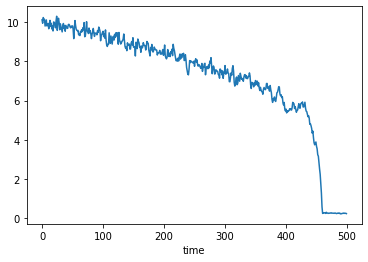

In [11]:
series.plot();

## Initialise a TimeSeries object

Before computing EWS with *ewstools*, it is necessary to place your data inside a TimeSeries object. Your data can be in the form of a python list, a numpy array, or a pandas series. In the case of a pandas series, the index of your data will be carried forward throughout the analysis, which is preferable if you don't want arbitrary time points. You can also enter a transition time (optional), beyond which early warning signals will not be computed. Here we will enter a transtion time as the time at which the bifurcation parameter crosses the bifurcation.

In [13]:
ts = ewstools.TimeSeries(data=series, transition=tbif)

The TimeSeries object has several attributes worth knowing about:

| Attribute | Type | Notes |
| :- | :- | :- |
| transition  | float | transition time (if defined) | 
| state  | pd.DataFrame | dataframe containing raw time series data and any detrending | 
| ews  | pd.DataFrame | dataframe containing any EWS computed | 
| ktau  | dict | dictionary containing Kendall tau values | 
| dl_preds  | pd.DataFrame | dataframe containing predictions from deep learning classifiers | 



To begin with, these attributes should all be empty, except for *transition* (if defined) and *state*, where you should see your data:

In [14]:
ts.state.head()

,state
time,
0,10.108165
1,9.937233
2,10.226274
3,10.124893
4,10.134140


## Detrend the data (if necessary)

You can detrend your data with either a Lowess or a Gaussian filter. You'll need to select a bandwidth (for Gaussian) or a span (for Lowess). Advice on choosing an appropriate parameters for detrending can be found in [Dakos et al. (2012)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0041010). Note you can define your bandwidth/span as either an absolute number of data points, or a proportion of the number of data points prior to the transition.

Let's detrend our data using a Lowess filter with a span of 0.2. After applying the method *detrend*() to the TimeSeries class, we see that the attribute *state* contains the smoothed time series and residuals.

In [15]:
ts.detrend(method='Lowess', span=0.2)
ts.state.head()

,state,smoothing,residuals
time,,,
0,10.108165,10.010470,0.097695
1,9.937233,10.003826,-0.066593
2,10.226274,9.997185,0.229089
3,10.124893,9.990548,0.134345
4,10.134140,9.983914,0.150226


This can be plotted directly from a pandas DataFrame with the command:

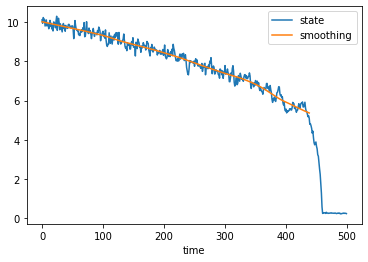

In [16]:
ts.state[['state','smoothing']].plot();

## Compute CSD-based early warning signals (EWS)

There are many signals in a time series that can indicate critical slowing down (CSD), thus providing a warning for a bifurcation. We refer to them as CSD-based EWS. They are computed over a rolling window with a size defined by the user. The rolling window can be given as a proporiton of the pre-bifurcation data, or an absolute number of data points. If you chose to detrend, EWS will be computed on the residual data. Otherwise, EWS will be computed on the raw data.

The table below lists the CSD-based EWS that can be computed by *ewstools* and their associated method:

| EWS  | Method | Notes |
| ------------- | ------------- | -------------- |
| variance  | compute_var( )  | Second moment of the data |
| skewness | compute_skew( )  | Standardised third moment of the data |
| kurtosis | compute_kurt( )  | Standardised fourth moment of the data |
| lag-tau autocorrelation | compute_ac( lag=tau )  | Correlation between the data and a shifted version (by tau) of itself |

Let's compute the variance, lag-1 autocorrelation and skew of our residual data prior to the fold bifurcation:

In [17]:
# Define rolling window length
rw = 0.5
ts.compute_var(rolling_window=rw)
ts.compute_auto(rolling_window=rw, lag=1)
ts.compute_skew(rolling_window=rw)

This will fill up the *ews* dataframe in the TimeSeries object. Let's take a look:

In [18]:
ts.ews.dropna().head()

,variance,ac1,skew
time,,,
218,0.039563,0.239890,-0.005122
219,0.039581,0.239445,0.007765
220,0.039784,0.244118,0.011943
221,0.039634,0.244150,0.028921
222,0.039770,0.244885,0.045630


Note the first values of this dataframe are Nan as a rolling window is used. Let's visualise the trajectory and EWS together using matplotlib:

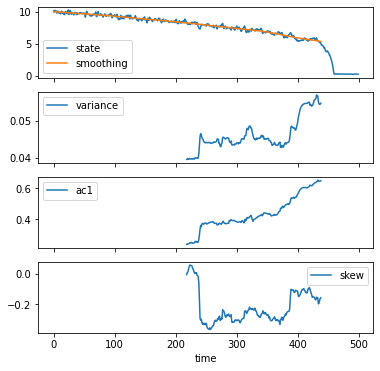

In [19]:
fig1, axes = plt.subplots(nrows=4, ncols=1, figsize=(6,6), sharex=True)
ts.state[['state','smoothing']].plot(ax=axes[0])
ts.ews['variance'].plot(ax=axes[1],legend=True)
ts.ews['ac1'].plot(ax=axes[2],legend=True);
ts.ews['skew'].plot(ax=axes[3],legend=True);

The variance and lag-1 autocorrelation show an increasing trend as a result of the critical slowing down phenomena that occurs prior to the bifurcation. The trend is the skew is less evident. One way to measure an increasing or decreasing trend is with the Kendall tau value. We can compute Kendall tau value for each EWS computed using the command:

In [20]:
ts.compute_ktau()

Now the *ktau* attribute should be filled.

In [23]:
ts.ktau

{'variance': 0.48630193336075694,
 'ac1': 0.8968325791855205,
 'skew': 0.24072398190045252}

If you are interested in computing the Kendall tau value between two specific times, this can also be specified with tmin and tmax, which are automatically set at the earliest and latest time present in the EWS trajectories. 

In [24]:
ts.compute_ktau(tmin=300, tmax=350)
ts.ktau

{'variance': 0.13568627450980394,
 'ac1': 0.7443137254901961,
 'skew': 0.22666666666666668}

## Compute DL classifier predictions

Deep learning classifiers were recently shown to be effective at predicting upcoming bifurcations and their type [(Bury et al. (2020)](https://www.pnas.org/doi/10.1073/pnas.2106140118). *ewstools* has the functionality to apply these types of classifier to time series data. For methods on how these classifiers are trained, please see the paper.

The method *apply_classifier( )* applies a TensorFlow classifier to the segment of time series data between *tmin* and *tmax* and appends the classification (a vector of probabilites for each class) to *TimeSeries.dl_preds*. The time of the classification is taken as *tmax*. 

Let's import a classifier that was trained in the study by [Bury et al.](https://www.pnas.org/doi/10.1073/pnas.2106140118), and apply it to the Ricker model simulation. For the classifiers in the study, the key is as follows:

| Key | Trajectory |
| :- | :- |
| 0 | fold bifurcation |
| 1 | Hopf bifurcation | 
| 2 | transcritical bifurcation |
| 3 | null |

In [25]:
# Import a classifier
classifier_path = '../saved_classifiers/bury_pnas_21/len500/best_model_1_1_len500.pkl'
classifier = load_model(classifier_path)

Let's apply the classifier to segments of increasing length. Each segment starts at the beginning of the raw time series. Therefore we will take *tmin* to be the start of the time series, and *tmax* to be incrementally larger values up to the transition time.

In [26]:
tmin = ts.state.index[0]
tmax_vals = np.arange(ts.state.index[50], ts.transition, 10)
# Apply the classifier for each value of tmax
for tmax in tmax_vals:
    ts.apply_classifier(classifier, name='c1', tmin=tmin, tmax=tmax, verbose=0)

2022-07-06 16:35:40.781833: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


The attribute *dl_preds* should now contain those predictions:

In [31]:
ts.dl_preds.head()

,0,1,2,3,time,classifier
0,0.167575,0.017197,0.164777,0.650452,50.0,c1
1,0.174397,0.070549,0.146668,0.608386,60.0,c1
2,0.172565,0.008006,0.153323,0.666106,70.0,c1
3,0.116711,0.004558,0.112423,0.766309,80.0,c1
4,0.093977,0.002228,0.083298,0.820497,90.0,c1


Let's visualise those DL predictions:

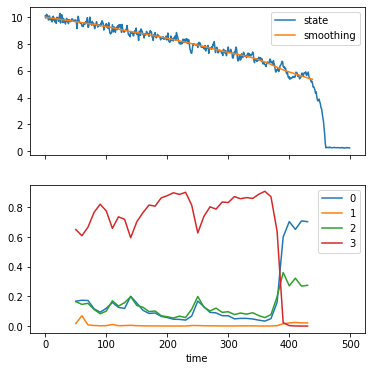

In [32]:
fig1, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,6), sharex=True)
ts.state[['state','smoothing']].plot(ax=axes[0])
ts.dl_preds.set_index('time')[[0,1,2,3]].plot(ax=axes[1],legend=True);

We should find that the DL classification favours the fold bifurcation ('0') as the bifurcation is approached.

#### Ensemble modelling

The previous predictions were obtained from a single classifier. To improve overall performance, we can use ensemble modelling, which involves taking the average of predictions from multiple classifiers. Let's import all 20 classifiers that were trained in the study by [Bury et al.](https://www.pnas.org/doi/10.1073/pnas.2106140118) (the classifiers that were trained on time series with 500 data points).

In [33]:
ts.clear_dl_preds() # we can clear previous DL predictions using this method
root_path = '../saved_classifiers/bury_pnas_21/len500/'
classifier_names = [name for name in os.listdir(root_path) if name[-4:]=='.pkl']

In [35]:
# Takes ~ 1 minutes to run on Macbook Air (M1, 2020)
# Loop through each classifier
for classifier_name in classifier_names[:4]:
    # Import classifier
    classifier = load_model(root_path + classifier_name)
    # Get DL predictions - note we can provide a classifier name for reference
    for tmax in tmax_vals:
        ts.apply_classifier(classifier, name=classifier_name, tmin=tmin, tmax=tmax, verbose=0)  
    print('Predictions complete for classifier {}'.format(classifier_name))

Predictions complete for classifier best_model_5_1_len500.pkl
Predictions complete for classifier best_model_2_1_len500.pkl
Predictions complete for classifier best_model_7_2_len500.pkl
Predictions complete for classifier best_model_6_2_len500.pkl


Now *dl_preds* should contain predictions made from multiple classifiers:

In [37]:
ts.dl_preds['classifier'].unique()

array(['best_model_5_1_len500.pkl', 'best_model_2_1_len500.pkl',
       'best_model_7_2_len500.pkl', 'best_model_6_2_len500.pkl'],
      dtype=object)

It remains to take the average prediction over all classfiers for each point in time:

In [40]:
df_dl_preds_av = ts.dl_preds.groupby(['time']).mean()
df_dl_preds_av.head()

,0,1,2,3
time,,,,
50.0,0.207920,0.206361,0.211997,0.373722
60.0,0.118032,0.229396,0.160266,0.492307
70.0,0.177907,0.087625,0.222411,0.512058
80.0,0.144341,0.053367,0.224743,0.577549
90.0,0.129807,0.036665,0.169316,0.664213


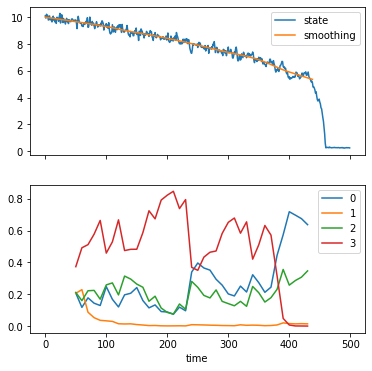

In [41]:
fig1, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,6), sharex=True)
ts.state[['state','smoothing']].plot(ax=axes[0])
df_dl_preds_av.plot(ax=axes[1],legend=True);

That's it! Feel free to copy and play around with this notebook for your own data.

In [42]:
# Stop timer
end_time = time.time()
print('Notebook took {:.1f}s to run'.format(end_time-start_time))

Notebook took 3323.9s to run
